# Data Analysis of Speech Text Files
This notebook will explore the text files provided by the assignment. 

In [53]:
import os, glob, re
import pandas as pd
import numpy as np

## Read Text Files

In [54]:
data_path = '../data/presidentspeeches/'
file_names = os.listdir('../data/presidentspeeches/')
file_names = [os.path.join(data_path,file) for file in file_names]

There were some errors with encoding that didn't allow us to iterate over the files, hence the ignore error argument.

In [55]:
text_dict = {}
for i, file in enumerate(file_names):
    num = ''.join(re.findall('[0-9]',file))
    with open(file,'r' , encoding='utf-8',errors='ignore') as file:
        text_dict[num] = file.read()

In [56]:
speeches = pd.Series(data= [text_dict[key] for key in text_dict.keys()],
                     index= [int(key) for key in text_dict.keys()],
                     name= 'speeches')
speeches = speeches.sort_index()

## Data Cleaning
### Test for duplicates

In [57]:
speeches.duplicated().any()

True

Uh oh! Let's find out which files are duplicates of each other

In [58]:
speeches.duplicated().sum()

1

We only have one duplicate. As the `.duplicated()` method automatically discards all except for the first or last occurence, we don't technically know how many times this document is duplicated.

In [59]:
print(speeches[speeches.duplicated(keep='first')])
print(speeches[speeches.duplicated(keep='last')])

119        To the Senate and House of Representatives...
Name: speeches, dtype: object
116        To the Senate and House of Representatives...
Name: speeches, dtype: object


In [60]:
duplicate = speeches[119]
for key, val in zip(speeches.index,speeches.values):
    if val == duplicate:
        print(key)

116
119


We have confirmed it is only two documents which are exact duplicates. After looking at both documents in their text files we confirm this, but of course we had to perform this process as a true data scientist before resorting to our lesser non-python ways.

In dealing with this dilemma, we will merely remove the second instance. We arbitrarily keep the first copy.

In [61]:
print('Length of speech series before removal:',len(speeches))
speeches = speeches[~speeches.duplicated(keep='first')]
print('Length of speech series after removal:',len(speeches))

Length of speech series before removal: 217
Length of speech series after removal: 216


In [62]:
#Let's make sure we do the same with our dictionary of text values 
del text_dict['119']

In [63]:
df = pd.DataFrame(speeches)

## Determine Most Frequent Words

In [67]:
#create a series of all the words in all the abstracts 
freq = pd.Series(''.join(df['speeches']).split())

In [84]:
hi_freq = freq.value_counts()[:20]
print('20 most common words in all speeches')
print('Word \t    Count')
print('-----------------')
print(hi_freq)

20 most common words in all speeches
Word 	    Count
-----------------
the      137096
of        96323
to        57360
and       56340
in        34331
a         25359
that      19854
be        18507
for       17652
is        16101
our       14545
by        14472
which     12125
have      11138
as        11079
with      11077
it         9765
this       9248
will       8628
been       8593
dtype: int64


In [86]:
lo_freq = freq.value_counts()[-20:]
print('20 least common words in all speeches')
print('Word \t    Count')
print('-----------------')
print(lo_freq)

20 least common words in all speeches
Word 	    Count
-----------------
Antarctica,          1
designed:            1
Delta.               1
bacteriological      1
theorists            1
653                  1
ministerial,         1
16,060               1
300,917,             1
well-distributed     1
plan.Certain         1
reentered            1
countries.An         1
Archipelago          1
inflation.BANKING    1
desk,                1
execution"           1
delegates.In         1
peacetime,           1
(16)                 1
dtype: int64


# Preprocessing
With this mild exploration under our belts, we are read to begin the critical preprocessing step. A processed corpus of text will often take the form of a massive matrix which is some interpretation of our word frequency values. Of course, many of these cells will contain zeros as in entirety, very few of our corpus words appear in very few of our corpus entries. 

This is the problem of *matrix sparsity*. For its size, our processed corpus matrix actually has very little information. Luckily, through the act of preprocessing we can minimize its impact on our model.

For this introduction to text mining, we will split text preprocessing into two key steps. 
- **Noise Removal**: Removing data components which are redundant to our text analytics and thus are be considered noise.
- **Normalization**: The process of handling multiple occurences or representations of the same word. Normalization can be further broken down into two types: *stemming* and *lemmatization*. 
 - **Stemming**: Text is normalized texts by removing suffixes and prefixes. i.e. *learned*, *learner*, and *learning* all become *learn*.
 - **Lemmatisation**: A more advanced technique which identifies the *root* of the word. 

To perform these operations, we look to the most common library for NLP workflow, the **Natural Language Toolkit Library**.

In [87]:
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

In [88]:
#Create list of stop words and add custom stopwords
stop_words = set(stopwords.words("english"))

#Display a random sample of 20 stopwords
pd.Series(list(stop_words)).sample(20).values

array(['which', 'hadn', 'me', 'through', 'both', 'he', 'than', 'now',
       'himself', 'here', 'some', 'been', 'again', 'needn', 'being',
       'few', 'other', 'can', 'in', 'just'], dtype=object)

In [89]:
corpus = {}

for key in text_dict.keys():
    #Remove punctuations
    #Our index is somewhat irregular (starts at zero, removed 119)
    
    try:
        text = re.sub('[^a-zA-Z]', ' ', text_dict[key])
    except:
        pass
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus[key] = text

In [90]:
text_dict['17']

'    The Senate and House of Representatives of the United States: At a moment when the nations of Europe are in commotion and arming against each other, and when those with whom we have principal intercourse are engaged in the general contest, and when the countenance of some of them toward our peaceable country threatens that even that may not be unaffected by what is passing on the general theater, a meeting of the representatives of the nation in both Houses of Congress has become more than usually desirable. Coming from every section of our country, they bring with them the sentiments and the information of the whole, and will be enabled to give a direction to the public affairs which the will and the wisdom of the whole will approve and support.In taking a view of the state of our country we in the first place notice the late affliction of two of our cities under the fatal fever which in latter times has occasionally visited our shores. Providence in His goodness gave it an early

In [91]:
corpus['17']

'senate house representative united state moment nation europe commotion arming principal intercourse engaged general contest countenance toward peaceable country threatens even may unaffected passing general theater meeting representative nation house congress become usually desirable coming every section country bring sentiment information whole enabled give direction public affair wisdom whole approve support taking view state country first place notice late affliction two city fatal fever latter time occasionally visited shore providence goodness gave early termination occasion lessened number victim usually fallen course several visitation disease appeared strictly local incident city tide water incommunicable country either person disease good carried diseased place access autumn disappears early frost restriction within narrow limit time space give security even maritime city three quarter year country always although fact appears unnecessary yet satisfy fear foreign nation caut

## Check New Frequencies for Words

In [101]:
corpus_df = pd.DataFrame().from_dict(corpus, orient='index')
corpus_df.columns = ['text']

In [110]:
#create a series of all the words in all the abstracts 
freq = pd.Series(''.join(corpus_df['text']).split())

In [113]:
hi_freq = freq.value_counts()[:20]
print('20 most common words in all speeches after preprocessing')
print('Word \t    Count')
print('-----------------')
print(hi_freq)

20 most common words in all speeches after preprocessing
Word 	    Count
-----------------
state         8483
government    7908
year          5894
congress      4919
united        4739
country       4221
upon          4042
people        4005
would         3762
nation        3570
may           3444
law           3395
great         3190
public        3149
made          3133
time          3129
must          3082
american      3026
war           2840
power         2814
dtype: int64


In [116]:
lo_freq = freq.value_counts()[-20:]
print('20 least common words in all speeches')
print('Word \t    Count')
print('-----------------')
print(lo_freq)

20 least common words in all speeches
Word 	    Count
-----------------
taxit            1
fossilization    1
helena           1
hesitant         1
swastika         1
mandan           1
positioned       1
eradicating      1
wheeler          1
coterie          1
majestic         1
bracing          1
carryovers       1
depredate        1
ingenuous        1
clapped          1
generalized      1
magnet           1
ebola            1
conataining      1
dtype: int64


# Join with Metadata
I've noticed that the files on record for the metadata don't match up perfectly with all the text files. We'll first see which numbers we don't have metadata for.

In [117]:
meta_df = pd.read_csv('../data/speechdetails.csv')
meta_df.head()

,Name,Year,File number,IC
0,G. Washington,1790,1,2.10
1,G. Washington,1790,2,2.00
2,G. Washington,1791,3,1.75
3,G. Washington,1792,4,1.40
4,J. Adam,1797,9,2.50


In [118]:
meta_df['File number']

0        1
1        2
2        3
3        4
4        9
5       10
6       11
7       12
8       13
9       14
10      15
11      16
12      21
13      22
14      23
15      24
16      29
17      30
18      31
19      32
20      37
21      38
22      39
23      40
24      41
25      42
26      43
27      44
28      49
29      50
      ... 
118    173
119    174
120    175
121    176
122    177
123    178
124    180
125    181
126    182
127    183
128    185
129    186
130    187
131    188
132    189
133    190
134    191
135    192
136    193
137    198
138    199
139    200
140    202
141    203
142    204
143    205
144    210
145    211
146    212
147    213
Name: File number, Length: 148, dtype: int64

In [119]:
meta_files = meta_df['File number'].values

unmatched = set(df.index.values)
for num in meta_files:
    if num in unmatched:
        unmatched.remove(num)
#unmatched now contains all the files with no meta_data
print('Number of unmatched rows:',len(unmatched))

Number of unmatched rows: 68


As we are unable to train or test on the unmatched samples, the best way to move forward with this discovery is to remove altogether the samples without metadata.

In [120]:
df = df.loc[~df.index.isin(unmatched)]

# Add Features

In [121]:
from feat_utils import add_feature_character_count, \
    add_feature_ngram_count, add_feature_overlap_ngrams, \
    add_feature_sentence_count, add_feature_unique_ngram_count, \
    add_feature_unique_ngram_ratio, add_feature_word_count

#Advanced features
from feat_utils import add_feature_tfidf_svd_similarity, \
    add_feature_w2v_similarity, add_feature_sentiment_sid

### Add basic count features

In [122]:
add_feature_character_count(df,'speeches')
add_feature_word_count(df,'speeches')
add_feature_sentence_count(df,'speeches')

/Users/Cooper/Desktop/Queens 2020/CMPE251/project/cmpe-final-project/notebooks/feat_utils.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['num_chars_%s' %(col)] = df[col].apply(lambda x: len(str(x)))
/Users/Cooper/Desktop/Queens 2020/CMPE251/project/cmpe-final-project/notebooks/feat_utils.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['num_word_%s' %(col)] = df[col].apply(lambda x: len(str(x).split(" ")))
/Users/Cooper/Desktop/Queens 2020/CMPE251/project/cmpe-final-project/notebooks/feat_utils.py:163: SettingWithCopyWarni

### Ngram related features

In [123]:
#uni, bi, and tri-gram count
add_feature_ngram_count(df,'speeches',1)
add_feature_ngram_count(df,'speeches',2)
add_feature_ngram_count(df,'speeches',3)

#unique uni, bi, and tri-gram count
add_feature_unique_ngram_count(df,'speeches',1)
add_feature_unique_ngram_count(df,'speeches',2)
add_feature_unique_ngram_count(df,'speeches',3)

#unique uni, bi, and tri-gram ratios
add_feature_unique_ngram_ratio(df,'speeches',1)
add_feature_unique_ngram_ratio(df,'speeches',2)
add_feature_unique_ngram_ratio(df,'speeches',3)

/Users/Cooper/Desktop/Queens 2020/CMPE251/project/cmpe-final-project/notebooks/feat_utils.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['count_%sgram_%s' %(n,col)] = df[col].apply(lambda x: len(generate_ngrams(x,n)))
/Users/Cooper/Desktop/Queens 2020/CMPE251/project/cmpe-final-project/notebooks/feat_utils.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['count_unique_%sgram_%s' %(n,col)] = df.apply(lambda x: len(set(generate_ngrams(x[col],n))),axis=1)
/Users/Cooper/Desktop/Queens 2020/CMPE251/project/cmpe-final-project/no

In [124]:
df

,speeches,num_chars_speeches,num_word_speeches,num_sents_speeches,count_1gram_speeches,count_2gram_speeches,count_3gram_speeches,count_unique_1gram_speeches,count_unique_2gram_speeches,count_unique_3gram_speeches,ratio_unique_1gram_speeches,ratio_unique_2gram_speeches,ratio_unique_3gram_speeches
1,Fellow-Citizens of the Senate and House of ...,6677,1079,10,1076,1075,1074,479,938,1048,0.445167,0.872558,0.975791
2,Fellow-Citizens of the Senate and House of...,8363,1396,29,1392,1391,1390,621,1211,1370,0.446121,0.870597,0.985612
3,Fellow-Citizens of the Senate and House of...,14075,2287,34,2276,2275,2274,871,1839,2165,0.382689,0.808352,0.952067
4,Fellow-Citizens of the Senate and House of...,12644,2078,35,2074,2073,2072,832,1728,1996,0.401157,0.833575,0.963320
9,Gentlemen of the Senate and Gentlemen of t...,12423,2057,42,2048,2047,2046,803,1687,1941,0.392090,0.824133,0.948680
10,Gentlemen of the Senate and Gentlemen of t...,13328,2203,34,2199,2198,2197,882,1828,2109,0.401091,0.831665,0.959945
11,Gentlemen of the Senate and Gentlemen of t...,9193,1503,27,1498,1497,1496,637,1246,1431,0.425234,0.832331,0.956551
12,Gentlemen of the Senate and Gentlemen of t...,8317,1358,24,1354,1353,1352,597,1170,1320,0.440916,0.864745,0.976331
13,Fellow Citizens of the Senate and House of...,19247,3200,62,3196,3195,3194,1209,2715,3128,0.378285,0.849765,0.979336
14,To the Senate and House of Representatives...,12906,2192,46,2183,2182,2181,888,1874,2140,0.406780,0.858845,0.981201


### Sentiment Features

In [125]:
add_feature_sentiment_sid(df,'speeches',avg=False) 

/Users/Cooper/Desktop/Queens 2020/CMPE251/project/cmpe-final-project/notebooks/feat_utils.py:289: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[key] = df2[key]


Sometimes there are null values for these columns

In [126]:
null_cols = [col for col in df.columns if 'sent_' in col]

In [127]:
for col in null_cols:
    df[col].fillna((df[col].mean()),inplace=True)

/Users/Cooper/anaconda3/envs/home/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [128]:
df.isnull().any()

speeches                       False
num_chars_speeches             False
num_word_speeches              False
num_sents_speeches             False
count_1gram_speeches           False
count_2gram_speeches           False
count_3gram_speeches           False
count_unique_1gram_speeches    False
count_unique_2gram_speeches    False
count_unique_3gram_speeches    False
ratio_unique_1gram_speeches    False
ratio_unique_2gram_speeches    False
ratio_unique_3gram_speeches    False
sent_compound_speeches         False
sent_neg_speeches              False
sent_neu_speeches              False
sent_pos_speeches              False
dtype: bool

### Comparison Features
**Idea**: There are many useful comparison-based features that we can use (TF-IDF & Word2Vec embedded differences). As we don't have a natural comparison between documents (as we might if we were comparing article headlines to body text) we can manufacture our own. Let's add as a feature the **TF-IDF & Word2Vec Similarity to the Min and Max integrative complexity article**.

Perhaps the TF-IDF matrix and Word2Vec embedding of sample speeches will capture some of the complexity. To do this, we will first need to identify the min and max scores of the ICs.

In [129]:
print('Maximum IC sample')
meta_df[meta_df['IC']== max(meta_df.IC.values)]

Maximum IC sample


,Name,Year,File number,IC
87,W.Taft,1909,121,3.75


In [130]:
print('Minimum IC sample')
meta_df[meta_df['IC']== min(meta_df.IC.values)]

Minimum IC sample


,Name,Year,File number,IC
35,J.Tyler,1844,56,1.0
38,J.Polk,1847,59,1.0
39,J.Polk,1848,60,1.0
70,C.Arthur,1884,96,1.0
94,W.Wilson,1916,128,1.0


As we have multiple speeches with low IC scores, we can try using the vectorized similarities of **each** as a feature, as well as a feature which averages their matrices (why not?).

To satisfy the structure of the feature generation functions we've created, we must add a column to the dataframe which has the text of the minimum and max scored speeches. For instance, adding a column as *min_IC_speech3*, and *max_IC_speech*. This is necessary because our function is built to extract the similarity of two entries in a row, and thus specifying each column is necessary. 

In [131]:
min_files = meta_df[meta_df['IC']== min(meta_df.IC.values)]['File number'].values
max_files = meta_df[meta_df['IC']== max(meta_df.IC.values)]['File number'].values

In [132]:
for i, num in enumerate(min_files):
    df['min_IC_speech'+str(i)] = text_dict[str(num)]
for i, num in enumerate(max_files):
    df['max_IC_speech'+str(i)] = text_dict[str(num)]

/Users/Cooper/anaconda3/envs/home/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Cooper/anaconda3/envs/home/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Create Comparison Features
These features are a touch more complex, and require us to pass models in as arguments.

#### TF-IDF Similarity Feature

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,3),max_df=0.8,min_df=2)

#Add in TFIDF difference for as many min_IC_speech columns we have
for col2 in [column for column in df.columns if 'min_IC_speech' in column]:
    add_feature_tfidf_svd_similarity(df,'speeches',col2, vectorizer)

#Do the same for max_IC_speech columns
for col2 in [column for column in df.columns if 'max_IC_speech' in column]:
    add_feature_tfidf_svd_similarity(df,'speeches',col2, vectorizer)

/Users/Cooper/Desktop/Queens 2020/CMPE251/project/cmpe-final-project/notebooks/feat_utils.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['sim_tfidf_%s_to_%sgram_%s_%s' %(vec.ngram_range[0],vec.ngram_range[1],col1,col2)] = list(map(cos_sim, tfidf1,tfidf2))


#### Word2Vec Similarity Features

In [134]:
#Import this 1.5GB model from Google!!!! (yikes)
import gensim 
model = gensim.models.KeyedVectors.load_word2vec_format('../../../../../Github/avengers-ensemble/eda_pipeline/GoogleNews-vectors-negative300.bin',binary=True)

/Users/Cooper/anaconda3/envs/home/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [135]:
#Add in W2V difference for as many min_IC_speech columns we have
for col2 in [column for column in df.columns if 'min_IC_speech' in column]:
    add_feature_w2v_similarity(df,'speeches',col2, model,1)

/Users/Cooper/Desktop/Queens 2020/CMPE251/project/cmpe-final-project/notebooks/feat_utils.py:250: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['sim_w2v_%s_%s' %(col1,col2)] = w2v_sims = np.squeeze(list(map(cos_sim, vecs1,vecs2)))
/Users/Cooper/Desktop/Queens 2020/CMPE251/project/cmpe-final-project/notebooks/feat_utils.py:250: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['sim_w2v_%s_%s' %(col1,col2)] = w2v_sims = np.squeeze(list(map(cos_sim, vecs1,vecs2)))
/Users/Cooper/Desktop/Queens 2020/CMPE251/project/cmpe-final-project/notebooks

AttributeError: 'float' object has no attribute 'split'

In [137]:
#Do the same for max_IC_speech columns
for col2 in [column for column in df.columns if 'max_IC_speech' in column]:
    add_feature_w2v_similarity(df,'speeches',col2, model,1)

/Users/Cooper/Desktop/Queens 2020/CMPE251/project/cmpe-final-project/notebooks/feat_utils.py:250: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['sim_w2v_%s_%s' %(col1,col2)] = w2v_sims = np.squeeze(list(map(cos_sim, vecs1,vecs2)))


AttributeError: 'float' object has no attribute 'split'

In [136]:
df

,speeches,num_chars_speeches,num_word_speeches,num_sents_speeches,count_1gram_speeches,count_2gram_speeches,count_3gram_speeches,count_unique_1gram_speeches,count_unique_2gram_speeches,count_unique_3gram_speeches,...,sim_tfidf_1_to_3gram_speeches_min_IC_speech1,sim_tfidf_1_to_3gram_speeches_min_IC_speech2,sim_tfidf_1_to_3gram_speeches_min_IC_speech3,sim_tfidf_1_to_3gram_speeches_min_IC_speech4,sim_tfidf_1_to_3gram_speeches_max_IC_speech0,sim_w2v_speeches_min_IC_speech0,sim_w2v_speeches_min_IC_speech1,sim_w2v_speeches_min_IC_speech2,sim_w2v_speeches_min_IC_speech3,sim_w2v_speeches_min_IC_speech4
1,Fellow-Citizens of the Senate and House of ...,6677,1079,10,1076,1075,1074,479,938,1048,...,0.0,0.0,0.0,0.0,0.0,0.980995,0.973205,0.974107,0.970233,0.976714
2,Fellow-Citizens of the Senate and House of...,8363,1396,29,1392,1391,1390,621,1211,1370,...,0.0,0.0,0.0,0.0,0.0,0.991216,0.985991,0.986884,0.981601,0.982088
3,Fellow-Citizens of the Senate and House of...,14075,2287,34,2276,2275,2274,871,1839,2165,...,0.0,0.0,0.0,0.0,0.0,0.991685,0.986393,0.987493,0.984941,0.982804
4,Fellow-Citizens of the Senate and House of...,12644,2078,35,2074,2073,2072,832,1728,1996,...,0.0,0.0,0.0,0.0,0.0,0.992950,0.989975,0.989267,0.987198,0.984325
9,Gentlemen of the Senate and Gentlemen of t...,12423,2057,42,2048,2047,2046,803,1687,1941,...,0.0,0.0,0.0,0.0,0.0,0.990334,0.991837,0.989366,0.986045,0.976113
10,Gentlemen of the Senate and Gentlemen of t...,13328,2203,34,2199,2198,2197,882,1828,2109,...,0.0,0.0,0.0,0.0,0.0,0.992414,0.987874,0.987967,0.983834,0.980726
11,Gentlemen of the Senate and Gentlemen of t...,9193,1503,27,1498,1497,1496,637,1246,1431,...,0.0,0.0,0.0,0.0,0.0,0.989232,0.987122,0.986139,0.984141,0.980237
12,Gentlemen of the Senate and Gentlemen of t...,8317,1358,24,1354,1353,1352,597,1170,1320,...,0.0,0.0,0.0,0.0,0.0,0.988901,0.983289,0.984187,0.978977,0.978545
13,Fellow Citizens of the Senate and House of...,19247,3200,62,3196,3195,3194,1209,2715,3128,...,0.0,0.0,0.0,0.0,0.0,0.989090,0.986639,0.985540,0.978328,0.983358
14,To the Senate and House of Representatives...,12906,2192,46,2183,2182,2181,888,1874,2140,...,0.0,0.0,0.0,0.0,0.0,0.989339,0.989118,0.988684,0.983812,0.976595


## Pickle Dataframe
We have a lot of features, let's save it as a pickle so we don't have to process the text each time!

In [138]:
df.to_pickle('../data/features_df.pkl')

## Histogram of All Features

In [139]:
df.columns

Index(['speeches', 'num_chars_speeches', 'num_word_speeches',
       'num_sents_speeches', 'count_1gram_speeches', 'count_2gram_speeches',
       'count_3gram_speeches', 'count_unique_1gram_speeches',
       'count_unique_2gram_speeches', 'count_unique_3gram_speeches',
       'ratio_unique_1gram_speeches', 'ratio_unique_2gram_speeches',
       'ratio_unique_3gram_speeches', 'sent_compound_speeches',
       'sent_neg_speeches', 'sent_neu_speeches', 'sent_pos_speeches',
       'min_IC_speech0', 'min_IC_speech1', 'min_IC_speech2', 'min_IC_speech3',
       'min_IC_speech4', 'max_IC_speech0',
       'sim_tfidf_1_to_3gram_speeches_min_IC_speech0',
       'sim_tfidf_1_to_3gram_speeches_min_IC_speech1',
       'sim_tfidf_1_to_3gram_speeches_min_IC_speech2',
       'sim_tfidf_1_to_3gram_speeches_min_IC_speech3',
       'sim_tfidf_1_to_3gram_speeches_min_IC_speech4',
       'sim_tfidf_1_to_3gram_speeches_max_IC_speech0',
       'sim_w2v_speeches_min_IC_speech0', 'sim_w2v_speeches_min_IC_speech1'

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

In [159]:
def histogramania(df,columns,shape):
    f, axes = plt.subplots(shape[0],shape[1])
    f.set_figheight(10)
    f.set_figwidth(15)
    axes = axes.flatten()
    f.tight_layout()
    f.suptitle('Histogram Plots for Preprocessed Speech Features')
    sns.set(font_scale=1.5)
    #Plots
    for i, col in enumerate(columns):
        plot = sns.distplot(df[col],ax=axes[i],kde=False)
    
    #Remove unused axes
    if len(axes) > len(columns):
        for idx in range(len(columns),len(axes)):
            axes[idx].remove ()

In [173]:
cols1 = ['num_chars_speeches', 'num_word_speeches',
       'num_sents_speeches', 'count_1gram_speeches', 'count_2gram_speeches',
       'count_3gram_speeches', 'count_unique_1gram_speeches',
       'count_unique_2gram_speeches', 'count_unique_3gram_speeches',
       'ratio_unique_1gram_speeches', 'ratio_unique_2gram_speeches',
       'ratio_unique_3gram_speeches', 'sent_compound_speeches',
       'sent_neg_speeches', 'sent_neu_speeches', 'sent_pos_speeches']

cols2 = ['sim_tfidf_min_IC0',
       'sim_tfidf_min_IC1',
       'sim_tfidf_min_IC2',
       'sim_tfidf_min_IC3',
       'sim_tfidf_min_IC4',
       'sim_tfidf_max_IC0',
       'sim_w2v_speeches_min_IC0', 'sim_w2v_speeches_min_IC1',
       'sim_w2v_speeches_min_IC2', 'sim_w2v_speeches_min_IC3',
       'sim_w2v_speeches_min_IC4', 'sim_w2v_speeches_max_IC0']

replace_cols = list(df.columns[:-12]) + cols2

In [175]:
df.columns = replace_cols
print(len(cols1))
print(len(cols2))

16
12


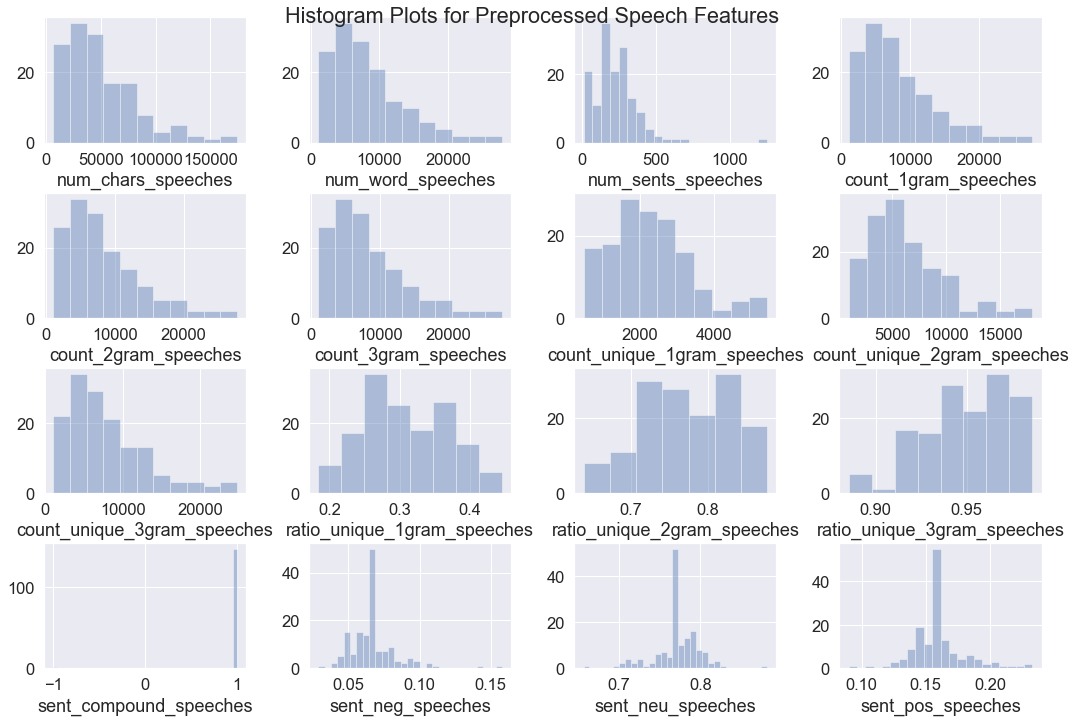

In [176]:
histogramania(df, cols1, [4,4])

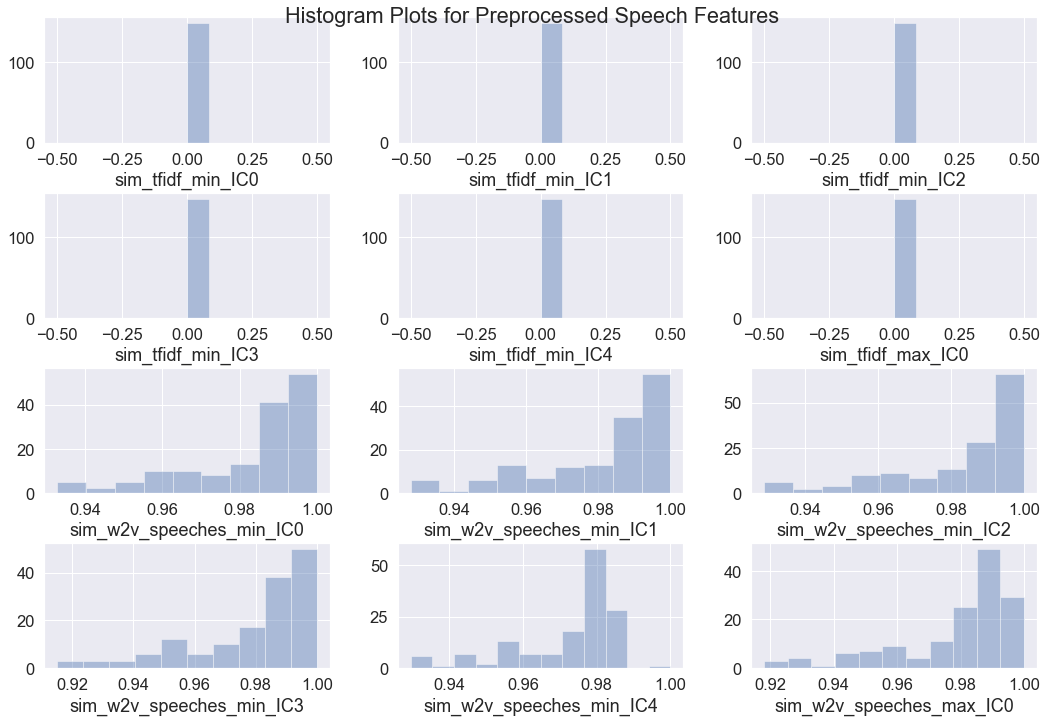

In [177]:
histogramania(df, cols2, [4,3])

## Word Cloud

In [178]:
from os import path 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

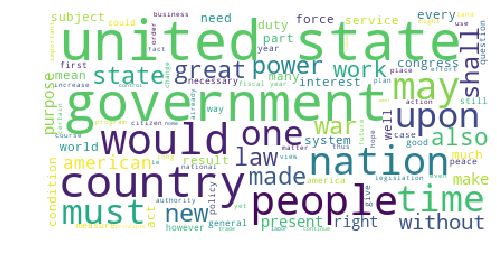

In [181]:
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
#print(wordcloud)
fig = plt.figure(1,figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("../figs/wordcloud.png", dpi=900)